In [7]:
import numpy as np
import pandas as pd
from functools import reduce
import pickle
import matplotlib.pyplot as plt
import random
import glob
import re
from lifetimes.utils import summary_data_from_transaction_data
# from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torchbnn as bnn
# import torchvision.transforms as transforms
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
import time
from customized.model import vae
from customized import preprocess
from customized import metrics
from customized.model import rnns

### Load utilities

### Data preprocessing (1 hr)

In [2]:
# ### read data ###
# s = time.time()
# data = {'prod':'商品資料_202103_202204/', 'txn':'銷售資料_202103_202204/*/', 'cmt':'*/*/'}
# end_date = '2022-04-30'
# for k,v in data.items():
#     globals()[k] = read_data(v)
# e = time.time()
# print(f'spent: {(e-s)/60:.4f} mins')

# ### clean data ###
# # 統一id
# name = ['邦成-自倉（C倉出貨付款全開）', '邦成-自倉(抓單)', '251.TC(貳伍壹潮流店)', '拼鮮水產 足度男直播買賣', '蔥媽媽直播', '工讀生寵物', '279-🛒現貨直播車', '夢工場', 'TR Box寶藏屋：傘的專家、居的職人', '阿清服裝']
# code = sorted(list(set(txn.user_id)))
# user_dict = dict(zip(name, code))
# for k, v in user_dict.items():
#     prod['user_id'] = prod['user_id'].str.replace(k, v, regex=False)
    
# # 拼鮮水產 足度男
# prod.user_id[(prod.user_id == '17614') | (prod.user_id == '27343')] = '27343'
# txn.user_id[(txn.user_id == '17614') | (txn.user_id == '27343')] = '27343'
# cmt.user_id[(cmt.user_id == '17614') | (cmt.user_id == '27343')] = '27343'
# # 公主派對
# prod.user_id[(prod.user_id == '10891') | (prod.user_id == '11566')] = '10891'
# txn.user_id[(txn.user_id == '10891') | (txn.user_id == '11566')] = '10891'
# cmt.user_id[(cmt.user_id == '10891') | (cmt.user_id == '11566') | (cmt.user_id == '11498') | (cmt.user_id == '11600') | (cmt.user_id == '11618') | (cmt.user_id == '11717')] = '10891'
# # 刪除不合理的訂單
# txn = txn[txn.總金額>0]
# txn = txn[txn.asid != 'blank']
# # 時間格式
# txn.時間戳記 = pd.to_datetime(txn.時間戳記).dt.time
# txn.下單日期 = pd.to_datetime(txn.下單日期)
# cmt.created_time = pd.to_datetime(cmt.created_time.dt.date)

# ### complement product missing data ###
# tmp = pd.read_excel('data/商品資料_202103_202204/商品資料_缺失.xlsx', index_col=None, header=0, engine='openpyxl',
#                  converters={
#                      'id':str,
#                      'shipping_fee':bool,
#                      'cold_shipping':bool,
#                      'ship_alone':bool,
#                      'preorder':bool,
#                      'cal_shipping_free_excluded':bool
#                      }
#                 )
# tmp.iloc[:, [3,4,6]] = tmp.iloc[:, [3,4,6]].astype('int64')
# not_in_prod = list(set(txn.商品id).difference(set(prod.id)))
# not_in_prod = [x for x in not_in_prod if str(x) != 'nan']
# tmp = tmp.merge(txn[txn.商品id.isin(not_in_prod)][['商品id','user_id']].rename(columns={'商品id':'id'}).drop_duplicates('id', keep='first'), how='left', on='id')
# prod = pd.concat([prod, tmp]).sort_values(by=['id'])
# ### save to pickle ###
# pd.to_pickle(prod, 'data/prod.pkl')
# pd.to_pickle(txn, 'data/txn.pkl')
# pd.to_pickle(cmt, 'data/cmt.pkl')

# User Context Model
### GRU models for Classfication

## Customer-Streamer Model (3 mins)

In [2]:
prod = pd.read_pickle('data/prod.pkl')
txn = pd.read_pickle('data/txn.pkl')
cmt = pd.read_pickle('data/cmt.pkl')
end_date = '2022-11-01' # 半年

In [3]:
txn.user_id.value_counts() # 4123: 蔥媽媽; 4460: 寵物

6835     2514874
6897     1414138
10891    1119060
12235     170199
4793      167518
6112      155538
27343     113298
4460       42659
4123        3723
Name: user_id, dtype: int64

In [4]:
sub_txn = txn[txn.user_id.isin(['10891','12235','6112','6835','6897','4460','4793'])]
sub_txn.user_id.value_counts()
streamer_static_fname='streamer_static_features_7.csv'
# streamer_static_fname='streamer_static_features_9.csv'

In [8]:
labels_k # 3蔥媽媽,2拼鮮水產,4寵物,6夢工廠

{'10891': 0, '12235': 1, '4460': 2, '4793': 3, '6112': 4, '6835': 5, '6897': 6}

In [5]:
rfm, static_df = preprocess.generate_static_user_context(sub_txn, end_date)
streamer = preprocess.generate_streamer_features(streamer_static_fname, sub_txn, prod, cmt, rfm, end_date) # 製作streamer features
scale_streamer = preprocess.standardize(streamer)     # 標準化

Sequence legth:  5 Batch size: 32
付款單號不等於t筆: 0
(55079, 115)
(55079,)
Epoch [1/10], Step [1000/1154], Loss: 0.0909
Epoch [2/10], Step [1000/1154], Loss: 0.0406
Epoch [3/10], Step [1000/1154], Loss: 0.1733
Epoch [4/10], Step [1000/1154], Loss: 0.0717
Epoch [5/10], Step [1000/1154], Loss: 0.0782
Epoch [6/10], Step [1000/1154], Loss: 0.4308
Epoch [7/10], Step [1000/1154], Loss: 0.2202
Epoch [8/10], Step [1000/1154], Loss: 0.1663
Epoch [9/10], Step [1000/1154], Loss: 0.0926
Epoch [10/10], Step [1000/1154], Loss: 0.1990
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4064
           1       0.88      0.84      0.86      1724
           2       0.95      0.93      0.94       414
           3       0.91      0.93      0.92       949
           4       0.93      0.90      0.92       889
           5       0.95      0.96      0.96      3992
           6       0.94      0.95      0.95      6145

    accuracy                           0.94   

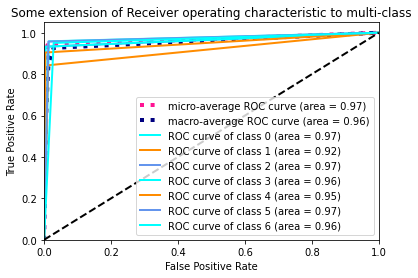

Sequence legth:  10 Batch size: 32
付款單號不等於t筆: 0
(32573, 230)
(32573,)
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2383
           1       0.85      0.80      0.83       877
           2       0.93      0.87      0.90       175
           3       0.94      0.91      0.93       580
           4       0.90      0.86      0.88       296
           5       0.96      0.96      0.96      2679
           6       0.94      0.95      0.94      3760

    accuracy                           0.94     10750
   macro avg       0.92      0.90      0.91     10750
weighted avg       0.94      0.94      0.94     10750

Finall Accuracy: 93.6744 %


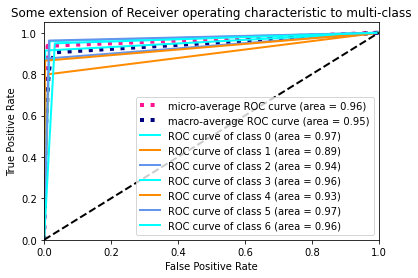

Sequence legth:  15 Batch size: 32
付款單號不等於t筆: 0
(21789, 345)
(21789,)
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1515
           1       0.91      0.70      0.79       569
           2       0.91      0.88      0.89        97
           3       0.92      0.93      0.93       359
           4       0.85      0.90      0.87       138
           5       0.96      0.96      0.96      1987
           6       0.92      0.97      0.94      2526

    accuracy                           0.93      7191
   macro avg       0.92      0.90      0.90      7191
weighted avg       0.93      0.93      0.93      7191

Finall Accuracy: 93.4641 %


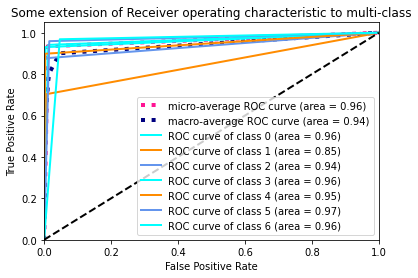

Sequence legth:  5 Batch size: 64
付款單號不等於t筆: 0
(55079, 115)
(55079,)
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4064
           1       0.90      0.82      0.86      1724
           2       0.97      0.92      0.95       414
           3       0.93      0.91      0.92       949
           4       0.93      0.90      0.92       889
           5       0.95      0.96      0.95      3992
           6       0.93      0.96      0.95      6145

    accuracy                           0.94     18177
   macro avg       0.94      0.92      0.93     18177
weighted avg       0.94      0.94      0.94     18177

Finall Accuracy: 93.8659 %


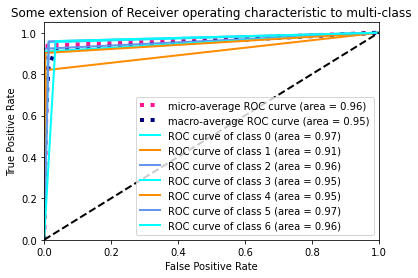

Sequence legth:  10 Batch size: 64
付款單號不等於t筆: 0
(32573, 230)
(32573,)
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2383
           1       0.87      0.77      0.82       877
           2       0.89      0.90      0.89       175
           3       0.94      0.91      0.92       580
           4       0.91      0.85      0.88       296
           5       0.96      0.95      0.96      2679
           6       0.93      0.95      0.94      3760

    accuracy                           0.93     10750
   macro avg       0.92      0.90      0.91     10750
weighted avg       0.93      0.93      0.93     10750

Finall Accuracy: 93.4419 %


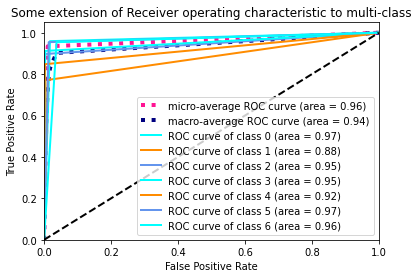

Sequence legth:  15 Batch size: 64
付款單號不等於t筆: 0
(21789, 345)
(21789,)
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1515
           1       0.87      0.77      0.82       569
           2       0.95      0.89      0.91        97
           3       0.95      0.92      0.93       359
           4       0.88      0.89      0.88       138
           5       0.96      0.95      0.96      1987
           6       0.94      0.96      0.95      2526

    accuracy                           0.94      7191
   macro avg       0.92      0.91      0.91      7191
weighted avg       0.94      0.94      0.94      7191

Finall Accuracy: 93.7561 %


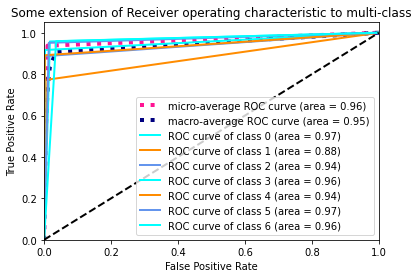

In [7]:
t_record = []
batch_record = []
acc_record = []
samples = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 125 # 25 dim x t seq x 1
num_epochs = 10
learning_rate = 0.001
hidden_size = 128
num_layers = 1
num_classes = streamer.shape[0]
input_size = streamer.shape[1]
batch_list = [32, 64]
t_list = [5, 10, 15] # [i for i in range(5, 11)]

for b,t in itertools.product(batch_list, t_list):
    print("Sequence legth: ", t, "Batch size:", b)

    ### preprocess streamer data ###
    txn_n = preprocess.generate_last_n_txn(sub_txn, t, end_date)        # 找出最後n次交易
    s_seq = preprocess.generate_streamer_seq(txn_n, scale_streamer, t)  # input sequences
    print(s_seq.shape)
    labels_k = dict(zip(streamer.index.to_list(), [i for i in range(streamer.shape[0])])) # user_id as key
    # labels_v = dict(enumerate(streamer.index.to_list())) # user_id as value
    s_labels = preprocess.generate_streamer_targets(txn_n, labels_k) # label sequences' targets
    print(s_labels.shape)
    ### preprocess streamer data ###
    
    x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(s_seq, s_labels, test_size=0.33, random_state=2022) # split data

    batch_size = b
    sequence_length = t

    # Read & transform data
    train_dataset = preprocess.StreamerDataset(x_s_train, y_s_train)
    test_dataset = preprocess.StreamerDataset(x_s_test, y_s_test)

    # Load data
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True) # 訓練模型時打亂順序
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False) # 測試集不需要打亂結果也是一樣(因為沒有訓練，是拿已訓練完畢的模型直接產出結果)

    model = rnns.GRU(input_size, hidden_size, num_layers, num_classes).to(device) # (batch, 26, t), 128, 2, 9

    # Loss and optimizer
    loss_funtion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    # Train the model
    n_total_steps = len(train_loader) # total sample/N 批次
#     train_preds = []
#     train_trues = []
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader): # 共 n_total_steps * N 人 -> 迭代 n_total_steps 次, 一批次 N 人
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
            loss = loss_funtion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 1000 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
#             train_outputs = outputs.argmax(dim=1)
#             train_preds.extend(train_outputs.detach().cpu().numpy())
#             train_trues.extend(labels.detach().cpu().numpy())
#         print(classification_report(train_trues, train_preds))
    torch.save(model.state_dict(), 'trained_model/customer_streamer/gru_'+str(b)+'_'+str(t)+'.pth')
    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    test_preds = []
    test_trues = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            test_preds.extend(predicted.detach().cpu().numpy())
            test_trues.extend(labels.detach().cpu().numpy())
            
        acc = 100.0 * n_correct / n_samples
        print(classification_report(test_trues, test_preds))
        print(f'Finall Accuracy: {acc:.4f} %') 
        test_trues_bin = metrics.label_binarize(test_trues, classes=[i for i in range(num_classes)])
        test_preds_bin = metrics.label_binarize(test_preds, classes=[i for i in range(num_classes)])
        metrics.get_roc_auc(test_trues_bin, test_preds_bin, num_classes)
        acc_record.append(acc)
        batch_record.append(batch_size)
        t_record.append(t)
        samples.append(s_seq.shape[0])

In [8]:
import plotly.io as pio
pio.renderers.default = 'iframe'

df = pd.DataFrame(dict(
    t = t_record,
    acc = acc_record,
    batch_size = batch_record
))

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
head, tail, mul = 0, len(t_list), 1
for i in batch_list:
    fig.add_trace(
        go.Scatter(x=t_list, y=df.acc[head*tail:tail*mul], name="Batch Size="+str(i), mode='lines+markers'),
        secondary_y=True,
    )
    head += 1
    mul += 1

fig.add_trace(
    go.Bar(x=t_list, y=samples[:len(t_list)], name="# of Customers"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Customer-Streamer Model Performance", 
    template="plotly",
    hovermode="x unified"
)
# fig.update_traces(mode="markers+lines", hovertemplate=None)

# Set x-axis title"
fig.update_xaxes(title_text="t")

# Set y-axes titles
fig.update_yaxes(title_text="Number of Customers", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="Accuracy", range=[90,100], secondary_y=True, zeroline=False)

fig.show()

## Customer-Product Model

### Method-3. Product Name Embeddings w/t Features using Bert (for HUGE dataset)

In [10]:
with open('data/item2vec.pkl', 'rb') as f:
    item2vec = pickle.load(f)
len(item2vec)

247092

In [11]:
prod_n = preprocess.generate_last_n_prod(sub_txn, 5, end_date)        # 找出最後n次交易
prod_n

付款單號不等於t筆: 0


,asid,付款單號,商品id,cnt,seq
0,1000057940522534,PA210625-08456886,3740398,1,1
1,1000057940522534,PA210625-08456886,3740432,1,1
2,1000057940522534,PA210625-08456886,3742657,1,1
3,1000057940522534,PA210625-08456886,3742823,1,1
4,1000057940522534,PA210625-08456886,3743199,1,1
...,...,...,...,...,...
4504970,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612594,4978789,1,2
4504971,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612642,4978802,1,3
4504972,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612676,4978805,1,4
4504973,Ufd9f8919382ca4899c4090af496b7d8f,PA211017-11612691,4978807,1,5


### Method-1. Multi-hot Encoding (for SMALL dataset (2 weeks txn data) ONLY)

In [13]:
t_record2 = []
batch_record2 = []
acc_record2 = []
samples2 = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 125 # 25 dim x t seq x 1
num_epochs = 10
learning_rate = 0.001
hidden_size = 128
num_layers = 1
batch_list = [32, 64]
t_list = [5, 10, 15]
threshold = 0.5

for b,t in itertools.product(batch_list, t_list):
    print("Sequence length: ", t)

    ### preprocess streamer data ###
    prod_n = preprocess.generate_last_n_prod(sub_txn, t, end_date)        # 找出最後n次交易
    p_seq, p_targets = preprocess.generate_prod_seq_and_target(prod_n, t)  # input sequences
    print(p_seq.shape, p_targets.shape)
    ### preprocess streamer data ###
    
    x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(p_seq, p_targets, test_size=0.33, random_state=2022) # split data

    batch_size = b
    sequence_length = t
    input_size = p_targets.shape[1] # (p_seq.shape[1]/t).astype('int64') 

    # Read & transform data
    train_dataset = preprocess.BasketDataset(x_s_train, y_s_train)
    test_dataset = preprocess.BasketDataset(x_s_test, y_s_test)

    # Load data
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)

    model = rnns.GRU(input_size, hidden_size, num_layers, p_targets.shape[1]).to(device) # (5 batch, 25, 5), 128, 2, out_feature_dim

    # Loss and optimizer
    loss_funtion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    # Train the model
    n_total_steps = len(train_loader) # total sample/N 批次
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader): # 共 n_total_steps * N 人 -> 迭代 n_total_steps 次, 一批次 N 人
            # origin shape: [N, 1, 25, t]
            # resized: [N, 25, t] # N:batch
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
            loss = loss_funtion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 1000 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # multi-label prediction

            # 法一(小數點6後的尾數 因為把[True, True, False, ...]轉float做mean而與 轉int後加總相除 有些微落差)：
            # print("Accuracy: ", ((outputs > threshold) == labels).float().mean().item()) # Can only calculate the mean of floating types.
            # 法二(先轉換後，逐個計算)：
            outputs[outputs >= threshold] = 1
            outputs[outputs < threshold] = 0
            # print("Accuracy: ", (outputs == labels).sum().item()/(labels.shape[0]*labels.shape[1])) # 直接算product_accuracy
        
        acc = metrics.cal_accurracy_detail(answer=labels, prediction=outputs) # 看完整的資訊
        acc_record2.append(acc)
        batch_record2.append(batch_size)
        t_record2.append(t)
        samples2.append(p_seq.shape[0])

In [12]:
df = pd.DataFrame(dict(
    t = t_record2,
    acc = acc_record2,
    batch_size = batch_record2
))

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
head, tail, mul = 0, len(t_list), 1
for i in batch_list:
    fig.add_trace(
        go.Scatter(x=t_list, y=df.acc[head*tail:tail*mul], name="Batch Size="+str(i), 
                   mode='lines+markers', layout_yaxis_range=[0.5,1]),
        secondary_y=True,
    )
    head += 1
    mul += 1

fig.add_trace(
    go.Bar(x=t_list, y=samples2[:len(t_list)], name="# of Customers"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Customer-Product Model (Multi-hot Encoding) Performance", 
    template="plotly",
    hovermode="x unified"
)
# fig.update_traces(mode="markers+lines", hovertemplate=None)

# Set x-axis title"
fig.update_xaxes(title_text="t")

# Set y-axes titles
fig.update_yaxes(title_text="Number of Customers", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="Product Accuracy", range=[90,100], secondary_y=True, zeroline=False)

fig.show()

### Method-2. Product Features (for SMALL dataset (2 weeks txn data) ONLY)

In [22]:
prod.seller.value_counts()

直播    78
社團     9
粉專     6
商城     4
Name: seller, dtype: int64

In [11]:
prod.describe(include=object) # 無用變數: name, kind

,id,name,category,kind,supplier,seller,user_id
count,3631,3631,632,3631,187,97,3631
unique,3631,3402,77,1,17,4,8
top,6498505,316不鏽鋼陶晶煎烤盤(34公分)*1個,夏被,directbuy,林家禾,直播,6835
freq,1,13,69,3631,49,78,1075


In [12]:
prod.describe() # 無用變數: quantity, cal_shipping_free_excluded

,price,quantity,weight,shipping_fee,cold_shipping,ship_alone,preorder,cal_shipping_free_excluded
count,3631.000000,3631.000000,3631.000000,3631.000000,3631.000000,3631.000000,3631.000000,3631.0
mean,967.443955,880.821261,2.268796,0.998623,0.013495,0.000275,0.000275,0.0
std,1783.497591,2821.094490,2.851980,0.037088,0.115397,0.016595,0.016595,0.0
min,0.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,100.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
50%,398.000000,73.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
75%,1100.000000,982.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.0
max,23980.000000,49060.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [24]:
product = generate_prodcut_features(prod)
scale_prod = standardize(product)
prod_n = generate_last_n_prod(txn, t) # 找出最後n次交易
b_seq, rmlist = generate_basket_seq(prod_n, scale_prod, t)
rmlist

付款單號不等於t筆: 0
不在商品主檔的商品共有: 22個


In [13]:
t_record3 = []
batch_record3 = []
acc_record3 = []
samples3 = []

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 10
learning_rate = 0.001
input_size = 112
hidden_size = 128
num_layers = 1
batch_list = [32, 64]
t_list = [5, 10, 15]
threshold = 0.5

for b,t in itertools.product(batch_list, t_list):
    print("Sequence length: ", t)

    ### preprocess streamer data ###
    product = generate_prodcut_features(prod)
    scale_prod = standardize(product)
    prod_n = generate_last_n_prod(txn, t) # 找出最後n次交易
    b_seq, rmlist = generate_basket_seq(prod_n, scale_prod, t)
    b_targets = generate_basket_targets(prod_n, t)
    print(b_seq.shape, b_targets.shape)
    ### preprocess streamer data ###
    
    x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(b_seq, b_targets, test_size=0.33, random_state=2022) # split data

    batch_size = b
    sequence_length = t

    # Read & transform data
    train_dataset = BasketDataset(x_s_train, y_s_train)
    test_dataset = BasketDataset(x_s_test, y_s_test)

    # Load data
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)

    model = Model(input_size, hidden_size, num_layers, b_targets.shape[1]).to(device) # (5 batch, 25, 5), 128, 2, out_feature_dim

    # Loss and optimizer
    loss_funtion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    # Train the model
    n_total_steps = len(train_loader) # total sample/N 批次
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader): # 共 n_total_steps * N 人 -> 迭代 n_total_steps 次, 一批次 N 人
            # origin shape: [N, 1, 25, t]
            # resized: [N, 25, t] # N:batch
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs) # pytorch用法，網路上說應避免 model.forward(images) 這種寫法
            loss = loss_funtion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 2 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    # Test the model
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for inputs, labels in test_loader:
            inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # multi-label prediction

            # 法一(小數點6後的尾數 因為把[True, True, False, ...]轉float做mean而與 轉int後加總相除 有些微落差)：
            # print("Accuracy: ", ((outputs > threshold) == labels).float().mean().item()) # Can only calculate the mean of floating types.
            # 法二(先轉換後，逐個計算)：
            outputs[outputs >= threshold] = 1
            outputs[outputs < threshold] = 0
            # print("Accuracy: ", (outputs == labels).sum().item()/(labels.shape[0]*labels.shape[1])) # 直接算product_accuracy
        
        acc = cal_accurracy_detail(answer=labels, prediction=outputs) # 看完整的資訊
        acc_record3.append(acc)
        batch_record3.append(batch_size)
        t_record3.append(t)
        samples3.append(b_seq.shape[0])

Sequence length:  1
付款單號不等於t筆: 0
不在商品主檔的商品共有: 2044個
(6741, 112) (6741, 2591)
Epoch [1/2], Step [2/2258], Loss: 0.6932
Epoch [1/2], Step [4/2258], Loss: 0.6912
Epoch [1/2], Step [6/2258], Loss: 0.6853
Epoch [1/2], Step [8/2258], Loss: 0.6868
Epoch [1/2], Step [10/2258], Loss: 0.6723
Epoch [1/2], Step [12/2258], Loss: 0.6664
Epoch [1/2], Step [14/2258], Loss: 0.6762
Epoch [1/2], Step [16/2258], Loss: 0.6513
Epoch [1/2], Step [18/2258], Loss: 0.6432
Epoch [1/2], Step [20/2258], Loss: 0.6554
Epoch [1/2], Step [22/2258], Loss: 0.6584
Epoch [1/2], Step [24/2258], Loss: 0.6133
Epoch [1/2], Step [26/2258], Loss: 0.6288
Epoch [1/2], Step [28/2258], Loss: 0.6366
Epoch [1/2], Step [30/2258], Loss: 0.6123
Epoch [1/2], Step [32/2258], Loss: 0.5370
Epoch [1/2], Step [34/2258], Loss: 0.4861
Epoch [1/2], Step [36/2258], Loss: 0.5865
Epoch [1/2], Step [38/2258], Loss: 0.5076
Epoch [1/2], Step [40/2258], Loss: 0.4222
Epoch [1/2], Step [42/2258], Loss: 0.6662
Epoch [1/2], Step [44/2258], Loss: 0.3759
Epo

In [16]:
df = pd.DataFrame(dict(
    t = t_record3,
    acc = acc_record3,
    batch_size = batch_record3
))

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
head, tail, mul = 0, len(t_list), 1
for i in batch_list:
    fig.add_trace(
        go.Scatter(x=t_list, y=df.acc[head*tail:tail*mul], name="Batch Size="+str(i), mode='lines+markers'),
        secondary_y=True,
    )
    head += 1
    mul += 1

fig.add_trace(
    go.Bar(x=t_list, y=samples3[:len(t_list)], name="# of Customers"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text="Customer-Product Model (Features) Performance", 
    template="plotly",
    hovermode="x unified"
)
# fig.update_traces(mode="markers+lines", hovertemplate=None)

# Set x-axis title"
fig.update_xaxes(title_text="t")

# Set y-axes titles
fig.update_yaxes(title_text="Number of Customers", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="Product Accuracy", secondary_y=True, zeroline=False)

fig.show()